In [1]:
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import bayesian_blocks

from scipy.stats import ks_2samp
import scipy.stats as ss

import numpy as np

from vast.voidfinder.distance import z_to_comoving_dist

import matplotlib.pyplot as plt

In [2]:
# Kgals = Table.read('/home/codebind/Bootes/KOSS87.csv', format='ascii.csv')
# Kgals['dis'] = z_to_comoving_dist(np.array(Kgals['Redshift'],dtype=np.float32),0.315,1)
# Kgals.remove_column('Object Name')
# Kgals.sort('No.')
KNSA = Table.read('/home/codebind/Bootes/My Code/KNSA.txt', format = 'ascii.commented_header')
nsa = Table.read('/home/codebind/Bootes/NSA_Full.fits', format = 'fits')

In [3]:
catalog_SDSS = nsa[nsa['IN_DR7_LSS'] == 1]
del nsa

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]
del catalog_SDSS

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])

catalog_main = catalog_north[~strip_boolean]
del catalog_north

In [4]:
NSA = Table()
NSA['INDEX'] = catalog_main['index']
NSA['IAUNAME'] = catalog_main['IAUNAME']
NSA['RA'] = catalog_main['RA']
NSA['DEC'] = catalog_main['DEC']
NSA['Z'] = catalog_main['Z']
NSA['DIST'] = z_to_comoving_dist(np.array(catalog_main['Z'],dtype=np.float32),0.315,1)
NSA['MASS'] = catalog_main['ELPETRO_MASS']
NSA['SFR'] = catalog_main['SFR']
NSA['base_SFR'] = 10**NSA['SFR']
NSA['sSFR'] = catalog_main['sSFR']
NSA['base_sSFR'] = 10**NSA['sSFR']
NSA['ABSMAG'] = catalog_main['ELPETRO_ABSMAG'][:,4]
NSA['U-R'] = catalog_main['u_r']
del catalog_main

In [5]:
NSA = NSA[NSA['Z']>0 & np.isfinite(NSA['U-R'])]

In [6]:
# kra = Kgals['RA'] * u.deg
# kdec = Kgals['DEC'] * u.deg
# kdist = (Kgals['dis'] * u.Mpc).to(u.m)
# KSC = SkyCoord(kra, kdec,kdist)

# nra = NSA['RA'] *u.deg
# ndec = NSA['DEC'] * u.deg
# ndist = (NSA['DIST'] * u.Mpc).to(u.m)
# NSC = SkyCoord(nra,ndec,ndist)

# indices, D2D, D3D = KSC.match_to_catalog_sky(NSC)

# Kgals['NSA_index'] = indices
# Kgals['2D Dist'] = D2D
# Kgals['3D Dist'] = D3D

In [7]:
# KNSA = NSA[indices]
# KNSA.write('KNSA.txt', format= 'ascii.commented_header')

In [8]:
def two_bar_plot(set1, set2):
    '''
        set[0] = data
        set[1] = lower plotting bound of data set
        set[2] = upper plotting bound of data set
        set[3] = width of each bin
    '''
    
    bins1 = np.arange(set1[1], set1[2], set1[3])
    bins2 = np.arange(set2[1], set2[2], set2[3])
    
    y1, histbins1 = np.histogram(set1[0], bins1)
    y1_err = np.sqrt(y1)
    y1 = y1/len(set1[0])
    y1_err = y1_err/len(set1[0])
    bincenter1 = .5*(histbins1[1:] + histbins1[:-1])
    
    y2, histbins2 = np.histogram(set2[0], bins2)
    y2_err = np.sqrt(y2)
    y2 = y2/len(set2[0])
    y2_err = y2_err/len(set2[0])
    bincenter2 = .5*(histbins2[1:] + histbins2[:-1])
    
    fig, ax = plt.subplots(figsize = (10,6))
    ax.bar(bincenter1, y1, color = 'blue', alpha = 0.5, width = set1[3], yerr = y1_err, label = 'SDSS')
    ax.bar(bincenter2, y2, color = 'red', alpha = 0.5, width = set2[3], yerr = y2_err, label = 'KOSS87')
    
    return(fig, ax)

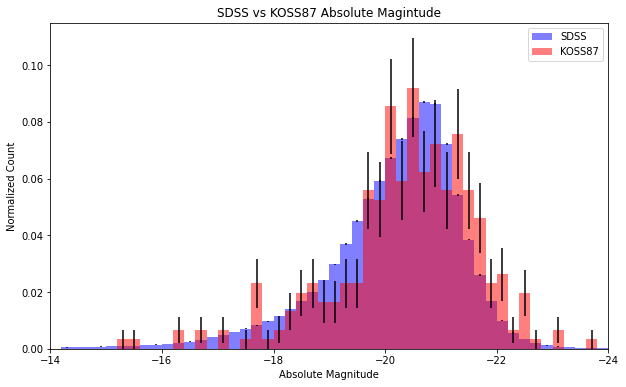

In [55]:
sdssmag = [NSA['ABSMAG'], -24, -14, 0.2]
kossmag = [KNSA['ABSMAG'], -24, -14, 0.2]
magfig, magax= two_bar_plot(sdssmag, kossmag)

plt.xlim(-14,-24)
magax.set_xlabel('Absolute Magnitude')
magax.set_ylabel('Normalized Count')
magax.set_title('SDSS vs KOSS87 Absolute Magintude')
magax.legend()

In [1]:
sdssur = [NSA['U-R'], 0, 5, 0.07]
kossur = [KNSA['U-R'], 0, 5, 0.1]
urfig, urax = two_bar_plot(sdssur, kossur)
urax.set_xlabel('u - r')
urax.set_ylabel('Normalized Count')
urax.set_title('SDSS vs KOSS87 Color')
urax.legend()

NameError: name 'NSA' is not defined

In [2]:
sdsssfr = [NSA['SFR'], -2.5, 2, .1]
kosssfr = [KNSA['SFR'], -2.5, 2, .2]
sfrfig,sfrax = two_bar_plot(sdsssfr, kosssfr)
sfrax.set_xlabel('SFR [log($M_{\odot} yr^{-1}$)]')
sfrax.set_ylabel('Normalized Count')
sfrax.set_title('SDSS vs KOSS SFR')
sfrax.legend()

NameError: name 'NSA' is not defined

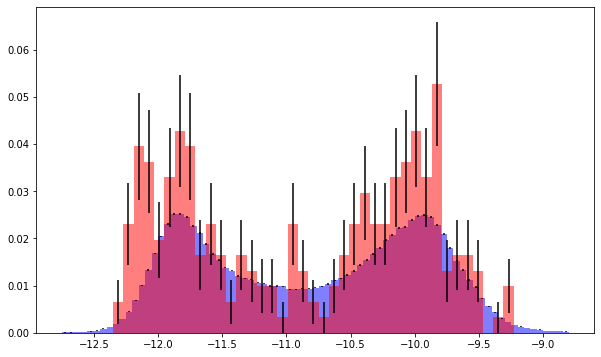

In [75]:
sdssssfr = [NSA['sSFR'], -12.75, -8.75, .05]
kossssfr = [KNSA['sSFR'], -12.75, -8.75, .08]
ssfrfig,ssfrax = two_bar_plot(sdssssfr, kossssfr)

/tmp/ipykernel_4383/2388886798.py:8: RuntimeWarning: divide by zero encountered in log10
  nsa_ax.hist(np.log10(NSA['MASS']), bins = mass_bin, color = 'blue', alpha = 0.6)


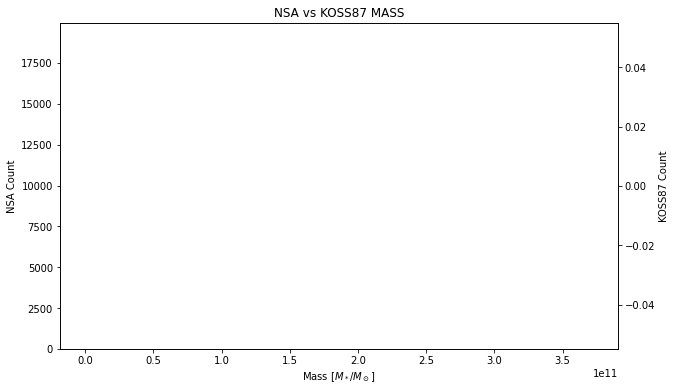

In [15]:
mass_bin = np.linspace(8, 12, 100)
smallmass_bin = bayesian_blocks(KNSA['MASS'], fitness = 'events', p0 = .1)
# smallmass_bin = np.linspace(8, 12, 50)

mass_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(np.log10(NSA['MASS']), bins = mass_bin, color = 'blue', alpha = 0.6)
knsa_ax.hist(np.log10(KNSA['MASS']), bins = smallmass_bin, color = 'red', alpha = 0.6)

nsa_ax.set(xlabel='Mass [$M_*/M_\odot$]')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 MASS')

fig = mass_fig
# fig.savefig('mass_hist.jpg', dpi = 120)

In [10]:
mag_test = ks_2samp(KNSA['ABSMAG'], NSA['ABSMAG'])
ur_test = ks_2samp(KNSA['U-R'], NSA['U-R'])
mass_test = ks_2samp(KNSA['MASS'], NSA['MASS'])
sfr_test = ks_2samp(KNSA['SFR'], NSA['SFR'])
ssfr_test = ks_2samp(KNSA['sSFR'], NSA['sSFR'])

In [11]:
print(mag_test)
print(ur_test)
print(mass_test)
print(sfr_test)
print(ssfr_test)

KstestResult(statistic=0.11067578982361528, pvalue=0.0010665888538301533)
KstestResult(statistic=0.08525088795692415, pvalue=0.02368754924528782)
KstestResult(statistic=0.08278761904947052, pvalue=0.02923004879225799)
KstestResult(statistic=0.04790232940003389, pvalue=0.6151895729580076)
KstestResult(statistic=0.09044254210655941, pvalue=0.03521480333624161)


Text(0.5, 1.0, 'Absolute Magnitude CDF')

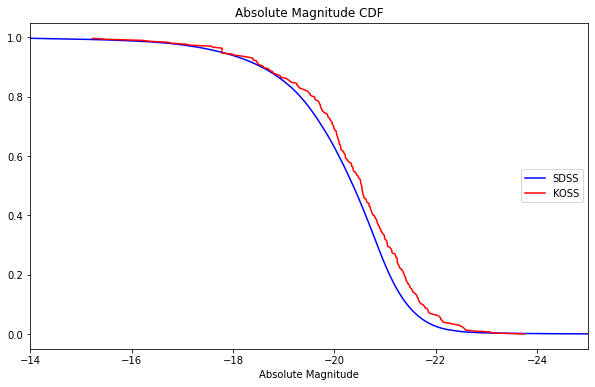

In [9]:
nN = len(NSA)
kN = len(KNSA)

nabsx = np.sort(NSA['ABSMAG'])
kabsx = np.sort(KNSA['ABSMAG'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nabsx, ny, color = 'blue', label = 'SDSS')
ax.plot(kabsx,ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-14,-25])
plt.xlabel('Absolute Magnitude')
plt.title('Absolute Magnitude CDF')

Text(0.5, 1.0, 'Color CDF')

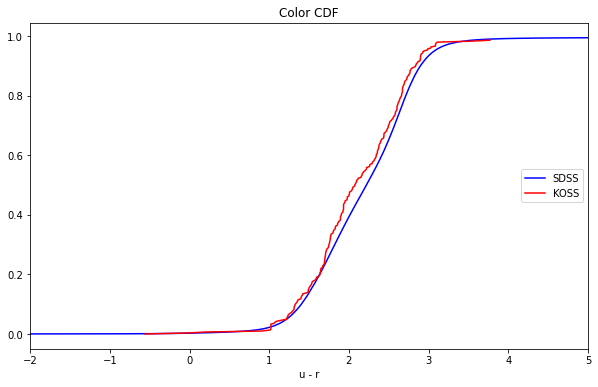

In [10]:
nN = len(NSA)
kN = len(KNSA)

nurx = np.sort(NSA['U-R'])
kurx = np.sort(KNSA['U-R'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nurx, ny, color = 'blue', label = 'SDSS')
ax.plot(kurx,ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-2,5])
plt.xlabel('u - r')
plt.title('Color CDF')

/tmp/ipykernel_5532/4112156914.py:4: RuntimeWarning: divide by zero encountered in log
  nmassx = np.sort(np.log(NSA['MASS']))


Text(0.5, 1.0, 'Stellar Mass CDF')

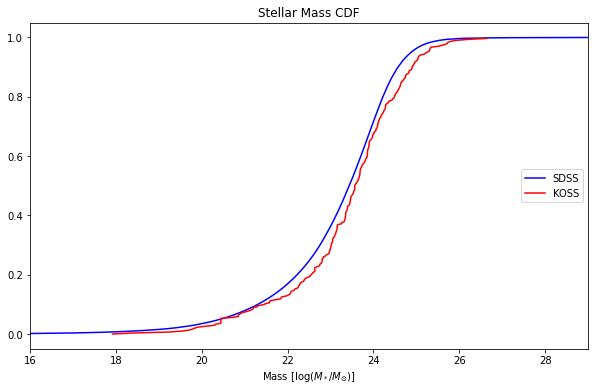

In [11]:
nN = len(NSA)
kN = len(KNSA)

nmassx = np.sort(np.log(NSA['MASS']))
kmassx = np.sort(np.log(KNSA['MASS']))

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nmassx, ny, color = 'blue', label = 'SDSS')
ax.plot(kmassx,ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([16,29])
plt.xlabel('Mass [log($M_* / M_{\odot}$)]')
plt.title('Stellar Mass CDF')

In [22]:
nN = len(NSA)
kN = len(KNSA)

nsfrx = np.sort(NSA['SFR'])
ksfrx = np.sort(KNSA['SFR'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

print(ksfrx[250])

# fig, ax = plt.subplots(figsize= (10,6))
# ax.plot(nsfrx, ny, color = 'blue', label = 'SDSS')
# ax.plot(ksfrx, ky, color = 'red', label = 'KOSS')
# ax.legend(loc = 'right')
# plt.xlim([-4,3])
# plt.xlabel('SFR [log($M_\odot yr^{-1}$)]')
# plt.title('Star Formation Rate CDF')

--


Text(0.5, 1.0, 'Specific Star Formation Rate CDF')

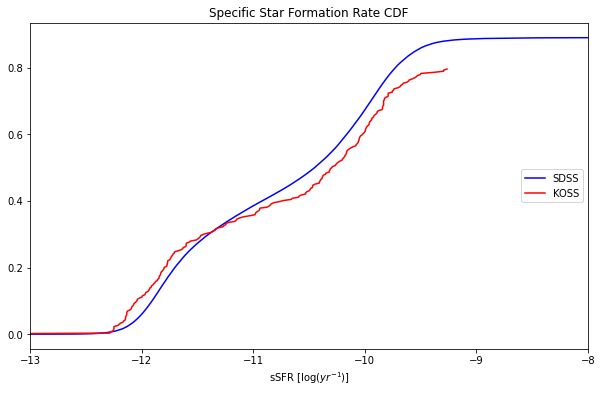

In [64]:
nN = len(NSA)
kN = len(KNSA)

nssfrx = np.sort(NSA['sSFR'])
kssfrx = np.sort(KNSA['sSFR'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nssfrx, ny, color = 'blue', label = 'SDSS')
ax.plot(kssfrx, ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-13,-8])
plt.xlabel('sSFR [log($yr^{-1}$)]')
plt.title('Specific Star Formation Rate CDF')